# Preparation

In [1]:
import random
from numpy import genfromtxt
import pandas as pd
import time
import numpy as np
import json
import scipy
from scipy import interpolate
import h5py
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from tqdm import tqdm

def open_file(path):
    df = pd.read_pickle(path)
    return df
def normalization(signal):
    if (np.max(signal)-np.min(signal))!=0:
        signal=(signal-np.min(signal))/(np.max(signal)-np.min(signal))
    signal=(signal-np.mean(signal))
    return signal

def upsample_acc(signal):
    y=signal
    x=np.arange(0,2*len(y),2)
    f= scipy.interpolate.interp1d(x,y,fill_value='extrapolate')
    x_new=np.arange(0,2*len(y))
    ynew=f(x_new)
    #ynew=pad(ynew)
    return(ynew)

def precompute_template_64(template):
    L=[None]
    print("computing template set... \n")
    for n in tqdm(range(1,5*64)):
        y=template
        x=np.arange(0,len(template))
        f= scipy.interpolate.interp1d(x,y,fill_value='extrapolate')
        x_new=np.linspace(0,len(template),n,endpoint=False)
        ynew=f(x_new)
        L.append(ynew)
    return L

def create_fakeppg(template,peak64):
    rpeak_t=peak64
    len_true_sign=len(df['signal']['wrist']['BVP'])
    out=np.array([])
    L=precompute_template_64(template)
    print("computing ppg... \n")
    discard=0
    for n in tqdm(range(len(rpeak_t)-1)):
        interval=int(rpeak_t[n+1]-rpeak_t[n])
        if interval!=0:
            ynew=L[interval]
            out=np.concatenate([out,ynew])
            if interval!=len(ynew):
                print(n)
        else:
            discard+=1
    print(discard)
    return rpeak_t,out


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def get_data_from_file(path,offset,final_template):
    df=open_file(path)
    List_data=[]
    List_label=[]
    List_hr=[]
    List_peaks=[]
    lowcut = 0.5
    highcut = 5
    sync_bvp=df['signal']['wrist']['BVP'][offset:,0]
    sync_peak=df['rpeaks']
    #sync_ecg=df['signal']['chest']['ECG'][sync_peak[0]:,0]
    first_peak_64index=int(np.round((sync_peak[0]/700)*64,0))
    sync_bvp_cut=sync_bvp[first_peak_64index:]
    sync_peak=sync_peak-sync_peak[0]
    sync_peak64=np.round((sync_peak/700)*64,0)
    sign_peak64=np.zeros(int(sync_peak64[-1]+1))
    peaktest,fakeppg_64hz=create_fakeppg(final_template,sync_peak64)
    for peak in sync_peak64:
        sign_peak64[int(peak)]=1
    sign_peak64=sign_peak64[:len(sync_bvp_cut)]
    sync_acc0_cut=upsample_acc(df['signal']['wrist']['ACC'][:,0])[offset:][first_peak_64index:]
    sync_acc1_cut=upsample_acc(df['signal']['wrist']['ACC'][:,1])[offset:][first_peak_64index:]
    sync_acc2_cut=upsample_acc(df['signal']['wrist']['ACC'][:,2])[offset:][first_peak_64index:]
    discard=0
    for k in tqdm(range(0,len(sync_bvp_cut)-5*64,64)):
        peak_list=np.where(sign_peak64[k:k+5*64]==1)[0]
        bvp_window=normalization(butter_bandpass_filter(sync_bvp_cut[k:k+5*64], lowcut, highcut, 64, order=1))
        acc0_window=normalization(butter_bandpass_filter(sync_acc0_cut[k:k+5*64], lowcut, highcut, 64, order=1))
        acc1_window=normalization(butter_bandpass_filter(sync_acc1_cut[k:k+5*64], lowcut, highcut, 64, order=1))
        acc2_window=normalization(butter_bandpass_filter(sync_acc2_cut[k:k+5*64], lowcut, highcut, 64, order=1))
        clean_ppg=normalization(butter_bandpass_filter(fakeppg_64hz[k:k+5*64], lowcut, highcut, 64, order=1))
        if len(peak_list)>=2:
            hr=np.mean([peak_list[n+1]-peak_list[n] for n in range(0,len(peak_list)-1)])
            List_data.append(np.array([bvp_window,acc0_window,acc1_window,acc2_window]))
            List_label.append(clean_ppg)
            List_hr.append(hr)
            List_peaks.append(peak_list)
        else :
            discard+=1
    print(discard)
    dic={}
    dic['label']=np.array(List_label)
    dic['data']=np.array(List_data)
    dic['hr']=np.array(List_hr)
    #dic['peaks']=List_peaks
    return dic

def create_ds():
    liste=["S{}".format(i,i) for i in range(1,16)]
    Offset_list=[120,120,118,130,95,107,118,123,54,116,120,117,117,118,120]
    h5f = h5py.File('data_PPG_Dalia_denoise_ppg_filtered.h5', 'w')
    try :
        for name in liste:
            print(name)
            path="./PPG_FieldStudy/{}/{}.pkl".format(name,name)
            dic=get_data_from_file(path,Offset_list[int(name[1])-1],final_template)
            print("passed")
            h5f.create_dataset("data_{}".format(name), data=dic['data'])
            h5f.create_dataset("label_{}".format(name), data=dic['label'])
            h5f.create_dataset("hr_{}".format(name), data=dic['hr'])
            #h5f.create_dataset("peaks_{}".format(name), data=dic['peaks'])
            print("passed h5")
    except : print("erreur")
    h5f.close()

In [1]:
def generate_template():
    df=open_file(str("./PPG_FieldStudy/S1/S1.pkl"))
    offset=120
    sync_bvp=df['signal']['wrist']['BVP'][offset:,0]
    sync_peak=df['rpeaks']
    sync_peak=sync_peak-sync_peak[0]
    sync_peak64=np.round((sync_peak/700)*64,0)
    template_0=sync_bvp[int(sync_peak64[0]):int(sync_peak64[1])]
    template_multi=np.concatenate([template_0,template_0,template_0])[:]
    kernel_size = 4
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(template_multi, kernel, mode='same')
    final_template=data_convolved[112:112+86]
    plt.plot(final_template)
    plt.show()

In [3]:
df=open_file(str("./PPG_FieldStudy/S1/S1.pkl"))
offset=120
sync_bvp=df['signal']['wrist']['BVP'][offset:,0]
sync_peak=df['rpeaks']
sync_ecg=df['signal']['chest']['ECG'][sync_peak[0]:,0]
first_peak_64index=int(np.round((sync_peak[0]/700)*64,0))
sync_bvp_cut=sync_bvp[first_peak_64index:]
sync_peak=sync_peak-sync_peak[0]
sync_peak64=np.round((sync_peak/700)*64,0)
sync_acc0_cut=upsample_acc(df['signal']['wrist']['ACC'][:,0])[offset:][first_peak_64index:]
sync_acc1_cut=upsample_acc(df['signal']['wrist']['ACC'][:,1])[offset:][first_peak_64index:]
sync_acc2_cut=upsample_acc(df['signal']['wrist']['ACC'][:,2])[offset:][first_peak_64index:]

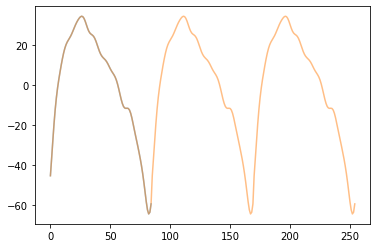

In [4]:
template_0=sync_bvp[int(sync_peak64[0]):int(sync_peak64[1])]
template_multi=np.concatenate([template_0,template_0,template_0])[:]
plt.plot(template_0,alpha=0.5)
plt.plot(template_multi,alpha=0.5)

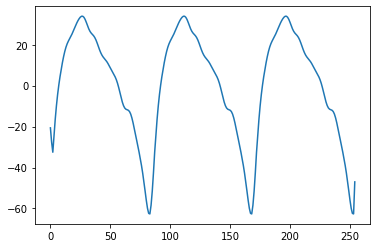

In [5]:
kernel_size = 4
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(template_multi, kernel, mode='same')
final_template=data_convolved[112:112+86]
plt.plot(data_convolved)

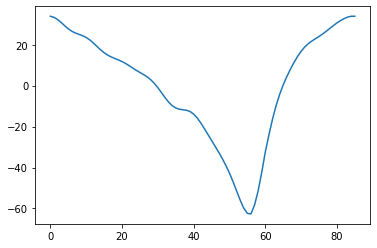

In [9]:
plt.plot(final_template)

# Sync

In [6]:
df=open_file(str("./PPG_FieldStudy/S1/S1.pkl"))
peaks=df['rpeaks']
first_peak_64index=int(np.round((peaks[0]/700)*64,0))
x2=df['signal']['wrist']['ACC'][first_peak_64index//2:,0]
x3=df['signal']['wrist']['ACC'][first_peak_64index//2:,1]
x4=df['signal']['wrist']['ACC'][first_peak_64index//2:,2]
acc=np.array([x2,x3,x4])
acc=np.linalg.norm(acc,axis=0)
ecg_cut=ecg=df['signal']['chest']['ECG'][peaks[0]:,0]
bvp_cut=df['signal']['wrist']['BVP'][first_peak_64index:,0]
peaks_cut=peaks-peaks[0]
peaks_cut64=np.round((peaks_cut/700)*64,0)
sign_peak64=np.zeros(int(peaks_cut64[-1]+1))
fakeppg_64hz=create_fakeppg(final_template,peaks_cut64)


computing template set... 



100%|██████████| 319/319 [00:00<00:00, 1226.84it/s]


computing ppg... 



 27%|██▋       | 3107/11430 [00:01<00:03, 2279.37it/s] 


KeyboardInterrupt: 

In [7]:
#fig, axs = plt.subplots(5,figsize=(15,15))
for k in range(0,200,10):
    deb=k*64
    offset=110
    step=5
    start_peak=((deb)/64)*700
    end_peak=((deb+step*64)/64)*700
    rpeak=[]
    for peak in peaks_cut:
        if (start_peak<=peak) and (peak<=end_peak):
            rpeak.append(peak)
    rpeak_t=(np.array(rpeak)/700)-(deb/64)
    ecg=ecg_cut[int(start_peak):int(end_peak)]
    Y=np.ones(len(rpeak_t))
    bvp=bvp_cut[offset+deb:offset+deb+step*64]
    cleanbvp=fakeppg_64hz[deb:deb+step*64]
    normacc=acc[(offset+deb)//2:(offset+deb+step*64)//2]
    plt.figure(figsize=(15,7))
    plt.plot(np.arange(0,len(bvp)/64,1/64),bvp/50)
    plt.scatter(rpeak_t,Y)
    plt.plot(np.arange(0,len(ecg)/700,1/700),ecg,alpha=0.5)
    plt.plot(np.arange(0,len(bvp)/64,1/64),cleanbvp/50)
    plt.plot(np.arange(0,len(normacc)/32,1/32),normacc,alpha=0.25)
    plt.title(k)

NameError: name 'fakeppg_64hz' is not defined

# Offset lists

In [12]:
L1_ind=[60,70,190,460,705,745,765,830,870,890,985,1000,1010,1025,1175,1200,1230,1305,1455,1580,1730,1820,1850,
    2000,2040,2070,2210,2320,2360,2370,2390,2470,2520,2600,2630,2660,2770,2910,3020,3160,3240,3340,3450,3790,
    3970,3980,4090,4290,4420,4540,4720,4900,5050,5190,5290,5470,5530,5640,5870,6030,6240,6640,6950,6990,7010,
    7060,7270,7320,7560,7660,7990,8160,8310,8980,9210]
L1_off=[120,115,120,115,118,115,120,115,112,115,112,115,118,115,119,125,130,135,140,142,145,149,152,154,150,146,
        144,142,144,146,148,152,154,152,154,156,158,165,160,164,167,170,175,180,175,170,165,162,159,155,158,157,
        150,143,138,135,133,128,124,120,116,112,108,104,105,100,95,92,89,86,80,77,73,68,62]
L2_ind=[30,120,730,800,910,980,1010,1120,1280,1305,1315,1335,1430,1465,1485,1500,1670,1740,1800,2260,2280,2410,2650,
        3000,3340,3410,3760,3975,4270,4400,4480,4640,4900,5020,5190,5520,6190,6530,6570,6710,7100,7180,7330,7440,7620,
        7760,7970,8015,8100,8190,8200]
L2_off=[108,112,116,120,125,128,125,122,126,123,128,126,129,123,126,122,124,130,126,123,120,115,122,126,131,134,138,132,126,
        129,136,132,127,123,119,115,110,114,111,108,106,104,102,100,95,90,85,80,78,80,76]
L3_ind=[25,40,80,160,340,400,495,560,675,700,717,840,855,875,950,1045,1105,1250,1310,1380,1470,1580,1710,1930,
        1965,2080,2115,2590,2710,2790,2920,3100,3290,3350,3400,3460,3600,3700,3770,3880,4140,4270,4370,4400,
        4560,4670,5020,5120,5380,5710,5810,6000,6010,6190,6320,6420,6450,6520,6570,6650,7310,7590,7635,7680,
        7970,8050,8710,8740]
L3_off=[118,108,112,118,124,128,124,121,117,112,108,103,100,97,94,91,95,91,94,98,102,104,108,111,115,120,124,120,
        124,126,128,126,129,132,134,137,140,144,148,152,156,158,160,163,165,169,167,164,161,158,154,151,148,145,141,138,134,
        132,129,127,124,128,130,134,130,133,130,126]
L4_ind=[130,240,540,640,680,730,820,950,1120,1250,1350,1460,1520,1620,1740,1810,1835,1850,1880,1910,2120,2150,2240,2370,2440,
        2510,2620,2700,2810,2930,2950,3140,3190,3210,3370,3390,3500,3640,3870,4220,4300,4330,4335,4340,4430,4590,4710,4730,
        4760,4850,4990,5030,5070,5220,5300,5400,5530,5600,5620,5930,6110,6660,6670,6780,6880,7030,7090,7120,7260,7360,7500,
        7650,7670,7850,7910,8080,8150,8200,8310,8610,8840,8890,8940,8980,8990,9120,9140]
L4_off=[115,120,125,122,118,112,105,102,98,94,98,101,105,102,105,108,105,108,112,109,112,115,119,123,127,123,126,123,119,122,119,115,112,115,
        118,122,120,118,114,110,106,102,106,103,102,98,95,100,105,103,106,109,111,114,119,124,128,131,134,138,134,131,128,124,120,
        114,118,121,124,127,131,135,139,142,144,148,152,156,160,164,160,156,154,150,154,153,149]
L5_ind=[250,390,940,1020,1380,1500,1570,1700,1760,1860,1980,2070,2100,2300,2620,2720,2820,2840,2970,3000,3100,
        3300,3480,3560,3640,3750,3860,4000,4070,4090,4140,4370,4420,4600,4640,4770,4860,4970,5040,5120,5300,5790,5870,
        5950,6100,6170,6340,6430,6500,6600,6700,6880,7140,7430,7510,7830,7940,8030,8180,8480,8710,8760,8940,8980,
        9060,9260,9280,9300]
L5_off=[105,100,97,94,92,96,99,103,106,109,112,115,118,120,115,118,122,125,128,132,134,131,128,125,128,130,134,137,134,131,
        128,125,123,126,129,134,131,129,125,121,118,114,117,120,123,126,130,133,137,140,144,147,151,148,153,158,154,150,146,
        142,138,142,140,138,135,131,129,127]
L6_ind=[60,130,260,450,510,610,738,750,930,950,980,1150,1380,1560,1800,1935,2170,2305,2430,2580,2840,2900,2950,3010,3030,3080,
        3130,3260,3430,3720,3810,3900,4340,4380,4440,4510,4570,4660,4790,5040,5100,5210,5240]
L6_off=[107,110,113,110,113,116,119,116,113,106,103,100,96,100,103,106,109,106,101,97,94,90,87,89,92,95,98,100,102,99,102,105,108,110,
        113,116,119,122,119,116,113,109,107]
L7_ind=[10,30,190,250,320,670,705,725,760,870,930,1065,1140,1250,1280,1295,1335,1370,1400,1450,1460,1530,1540,1560,1660,1690,
        1710,1860,1890,1940,1950,2010,2140,2280,2320,2400,2470,2600,2620,2660,2690,2735,2875,2940,2990,3060,3080,3100,3240,3300,
        3500,3580,3610,3860,3870,4000,4100,4225,4350,4460,4550,5040,5240,5330,5480,5600,5700,5750,5840,5980,6030,6170,6280,6410,
        6670,6820,6930,7060,7100,7220,7390,7430,7730,7920,7930,7950,8020,8130,8230,8290,8490,8820,9130,9340]
L7_off=[120,115,120,124,127,131,127,122,118,115,110,106,110,108,110,113,115,118,121,117,122,120,122,123,127,129,132,134,138,135,138,142,145,
        141,139,137,135,132,135,138,142,145,148,152,155,157,160,164,167,164,160,163,166,170,166,163,160,157,152,156,152,156,152,148,144,140,
        136,132,128,124,120,116,112,108,104,100,96,92,88,84,81,78,74,77,79,82,86,90,94,98,95,91,93,90]

In [13]:
Lists_offset_tstamp=[L1_ind,L2_ind,L3_ind,L4_ind,L5_ind,L6_ind,L7_ind]
Lists_offset_val=[L1_off,L2_off,L3_off,L4_off,L5_off,L6_off,L7_off]

# Create DS

In [45]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from tqdm import tqdm

def open_file(path):
    df = pd.read_pickle(path)
    return df

def generate_template():
    """ Generate the template for the fake ppg from file 1, with first bvp peak)"""
    df=open_file(str("./PPG_FieldStudy/S1/S1.pkl"))
    offset=120
    sync_bvp=df['signal']['wrist']['BVP'][offset:,0]
    sync_peak=df['rpeaks']
    sync_peak=sync_peak-sync_peak[0]
    sync_peak64=np.round((sync_peak/700)*64,0)
    template_0=sync_bvp[int(sync_peak64[0]):int(sync_peak64[1])]
    template_multi=np.concatenate([template_0,template_0,template_0])[:]
    kernel_size = 4
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(template_multi, kernel, mode='same')
    final_template=data_convolved[112:112+86]
    return final_template

def normalization(signal):
    """ Normalize a signal 
        y=(x-min(x))/(max(x)-min(x))
        return : y - mean(y)    
    """
    if (np.max(signal)-np.min(signal))!=0:
        signal=(signal-np.min(signal))/(np.max(signal)-np.min(signal))
    signal=(signal-np.mean(signal))
    return signal

def normalization_spectrum(spectrum):
    """ Normalize a signal 
        y=(x-min(x))/(max(x)-min(x))
        return : y - mean(y)    
    """
    if (np.max(spectrum)-np.min(spectrum))!=0:
        spectrum=(spectrum-np.min(spectrum))/(np.max(spectrum)-np.min(spectrum))
    return spectrum

def upsample_acc(signal):
    """ Use scipy to interpolate a signal and upsample it, here double the sampling of the signal"""
    y=signal
    x=np.arange(0,2*len(y),2)
    f= scipy.interpolate.interp1d(x,y,fill_value='extrapolate')
    x_new=np.arange(0,2*len(y))
    ynew=f(x_new)
    #ynew=pad(ynew)
    return(ynew)

def precompute_template_64(template):
    """ Precompute a set of template signal with variable size (more or less time) depending the inter heartbeat time
        return a list of each signal for each inter heartbeat time
    """
    L=[None]
    print("computing template set... \n")
    for n in tqdm(range(1,5*64)):
        y=template
        x=np.arange(0,len(template))
        f= scipy.interpolate.interp1d(x,y,fill_value='extrapolate')
        x_new=np.linspace(0,len(template),n,endpoint=False)
        ynew=f(x_new)
        L.append(ynew)
    return L

def create_fakeppg(template,peak64):
    """ Generate the entire fake ppg signal from the ecg signal peaks (peak64) and from the template"""
    rpeak_t=peak64
    #len_true_sign=len(df['signal']['wrist']['BVP'])
    out=np.array([])
    L=precompute_template_64(template)
    print("computing ppg... \n")
    discard=0
    for n in tqdm(range(len(rpeak_t)-1)):
        interval=int(rpeak_t[n+1]-rpeak_t[n])
        if interval!=0:
            ynew=L[interval]
            out=np.concatenate([out,ynew])
            if interval!=len(ynew):
                print(n)
        else:
            discard+=1
    print(discard)
    return out


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def gen_offsetlist(offset_tstamp,offset_value):
    """ Create a list of synchronizing offset to use for each second of the signal"""
    offset_list=np.zeros(offset_tstamp[-1])
    m=0
    for j in range(0,len(offset_tstamp)):
        for n in range(m,offset_tstamp[j]):
            offset_list[n]=offset_value[j]
        m=offset_tstamp[j]
    return offset_list


def time_freq_spectra(signal,window_size,step):
    """ compute the fft time frequency spectra of a signal given
        a signal
        a window_size (s)
        a step (s)
    """
    freq_bvp=64
    image=[]
    for k in range(0,len(signal)-window_size*freq_bvp,int(step*freq_bvp)):
        frac_sign=signal[k:k+window_size*freq_bvp]
        image.append(np.pad(frac_sign,(0,(64-window_size)*64),'constant',constant_values=(0,0))) #fft pre padding
    image=np.array(image)
    spectrum=np.float32(np.abs(np.fft.fft(image,axis=1)[:,:257]))
    return normalization_spectrum(spectrum).reshape((1,-1,257))



def get_data_from_file(path,offset_tstamp,offset_value,template):
    """ Extract data from the given file (path) 
    
    path : path of the file containing raw data
    offset_tstamp : list containing timestamp, each timestamp is the time boundary for each offset value
    offset_value : value to use to synchronize the fake ppg signal and the raw signal
    template : template used to create fake_ppg    
    
    """
    List_data=[]
    List_label=[]
    List_hr=[]
    List_spectrum=[]
    List_peaks=[]
    lowcut = 0.5  # lowcut freq for butterworth filter
    highcut = 5   # highcut freq for butterworth filter

    df=open_file(path)
    listoffset=gen_offsetlist(offset_tstamp,offset_value) # a list of synchronizing offset to use for each second of the signal
    peaks=df['rpeaks']
    first_peak_64index=int(np.round((peaks[0]/700)*64,0)) # index (in 64hz sampling) of the first peak of the ecg

    # 4 following signals are starting at the first ecg peak
    acc0_cut=upsample_acc(df['signal']['wrist']['ACC'][first_peak_64index//2:,0])
    acc1_cut=upsample_acc(df['signal']['wrist']['ACC'][first_peak_64index//2:,1])
    acc2_cut=upsample_acc(df['signal']['wrist']['ACC'][first_peak_64index//2:,2])
    bvp_cut=df['signal']['wrist']['BVP'][first_peak_64index:,0]

    peaks_cut=peaks-peaks[0] #first peak at t=0 (700hz sampling)
    peaks_cut64=np.round((peaks_cut/700)*64,0) #ecg peaks index (64hz sampling)
    sign_peak64=np.zeros(int(peaks_cut64[-1]+1))
    for peak in peaks_cut64:
        sign_peak64[int(peak)]=1
    #sign peak is a signal with 1 at the index of ecg peaks and 0 everywhere else

    fakeppg_64hz=create_fakeppg(template,peaks_cut64)
    
    discard=0
    for k in tqdm(range(0,(len(bvp_cut)//64)-12)):
        deb=k*64
        offset=int(listoffset[k])
        peak_list=np.where(sign_peak64[deb:deb+5*64]==1)[0]
        bvp_window=normalization(butter_bandpass_filter(bvp_cut[deb+offset:deb+offset+5*64], lowcut, highcut, 64, order=1))
        acc0_window=normalization(butter_bandpass_filter(acc0_cut[deb+offset:deb+offset+5*64], lowcut, highcut, 64, order=1))
        acc1_window=normalization(butter_bandpass_filter(acc1_cut[deb+offset:deb+offset+5*64], lowcut, highcut, 64, order=1))
        acc2_window=normalization(butter_bandpass_filter(acc2_cut[deb+offset:deb+offset+5*64], lowcut, highcut, 64, order=1))
        spec_bvp,spec_acc0,spec_acc1,spec_acc2=time_freq_spectra(bvp_window,3,0.5),time_freq_spectra(acc0_window,3,0.5),time_freq_spectra(acc1_window,3,0.5),time_freq_spectra(acc2_window,3,0.5)
        clean_ppg=normalization(butter_bandpass_filter(fakeppg_64hz[deb:deb+5*64], lowcut, highcut, 64, order=1))
        if len(peak_list)>=2:
            interbeat_mean=np.mean([peak_list[n+1]-peak_list[n] for n in range(0,len(peak_list)-1)])
            hr=60*64/interbeat_mean
            List_data.append(np.array([bvp_window,acc0_window,acc1_window,acc2_window]))
            List_label.append(clean_ppg)
            List_hr.append(hr)
            List_spectrum.append(np.concatenate((spec_bvp,spec_acc0,spec_acc1,spec_acc2),axis=0))
            #List_peaks.append(peak_list)
        else :
            discard+=1
    print(discard)
    dic={}
    dic['label']=np.array(List_label)
    dic['data']=np.array(List_data)
    dic['hr']=np.array(List_hr)
    dic['spectrum']=np.array(List_spectrum)
    #dic['peaks']=np.array(List_peaks)
    return dic

def create_ds():
    """ Create an h5 file containing data of extracted files"""
    template=generate_template()
    h5f = h5py.File('data_PPG_Dalia_denoise_ppg_filtered_and_spectrum_sync.h5', 'w')
    for i in range(1,8):
        try :
            path="./PPG_FieldStudy/S{}/S{}.pkl".format(i,i)
            print("S{}".format(i))
            dic=get_data_from_file(path,Lists_offset_tstamp[i-1],Lists_offset_val[i-1],template)
            name="S{}".format(i)
            h5f.create_dataset("data_{}".format(name), data=dic['data'])
            h5f.create_dataset("label_{}".format(name), data=dic['label'])
            h5f.create_dataset("hr_{}".format(name), data=dic['hr'])
            h5f.create_dataset("spectrum_{}".format(name), data=dic['spectrum'])
            #h5f.create_dataset("peaks_{}".format(name), data=dic['peaks'])
            print("S{} has been processed".format(i))
        except Exception as e:
            print(e)
            h5f.close()
    h5f.close()

In [43]:
import os
os.getcwd()

'c:\\Users\\Edouard\\Desktop\\Research Project\\PPG_Dalia'

In [173]:
import gc
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed


In [46]:
create_ds()

S1
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 6379.49it/s]


computing ppg... 



100%|██████████| 11430/11430 [00:08<00:00, 1335.22it/s]


0


100%|██████████| 9199/9199 [00:33<00:00, 277.99it/s]


0
S1 has been processed
S2
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 7088.31it/s]


computing ppg... 



100%|██████████| 11246/11246 [00:06<00:00, 1695.59it/s]


0


100%|██████████| 8192/8192 [00:26<00:00, 314.12it/s]


0
S2 has been processed
S3
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 5406.10it/s]


computing ppg... 



100%|██████████| 12927/12927 [00:08<00:00, 1533.37it/s]


0


100%|██████████| 8728/8728 [00:27<00:00, 314.79it/s]


0
S3 has been processed
S4
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 7418.16it/s]


computing ppg... 



100%|██████████| 13363/13363 [00:08<00:00, 1511.54it/s]


0


100%|██████████| 9137/9137 [00:28<00:00, 315.62it/s]


0
S4 has been processed
S5
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 5596.08it/s]


computing ppg... 



100%|██████████| 19505/19505 [00:13<00:00, 1496.59it/s]


0


100%|██████████| 9292/9292 [00:29<00:00, 314.46it/s]


0
S5 has been processed
S6
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 7418.03it/s]


computing ppg... 



100%|██████████| 10438/10438 [00:03<00:00, 3160.86it/s]


4


100%|██████████| 5237/5237 [00:16<00:00, 312.82it/s]


0
S6 has been processed
S7
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 5906.66it/s]


computing ppg... 



100%|██████████| 13414/13414 [00:08<00:00, 1503.02it/s]


0


100%|██████████| 9330/9330 [00:29<00:00, 315.29it/s]


0
S7 has been processed


In [174]:
i=1
path="./PPG_FieldStudy/S{}/S{}.pkl".format(i,i)
template=generate_template()
dic=get_data_from_file(path,Lists_offset_tstamp[i-1],Lists_offset_val[i-1],template)

S3
computing template set... 



100%|██████████| 319/319 [00:00<00:00, 7779.97it/s]


computing ppg... 



100%|██████████| 12927/12927 [00:09<00:00, 1368.10it/s]


0
8728
559393


100%|██████████| 8728/8728 [00:15<00:00, 577.62it/s]


0


In [158]:
gen_offsetlist(L2_ind,L2_off)

array([108., 108., 108., ...,  76.,  76.,  76.])

Text(0.5, 1.0, '4415')

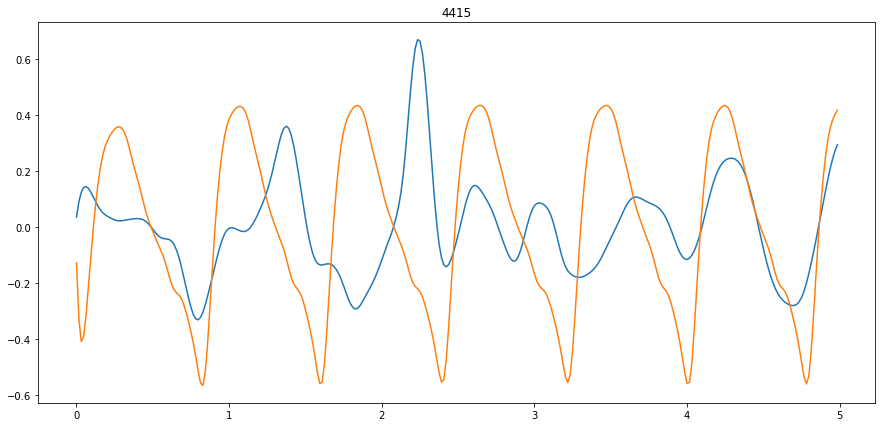

In [139]:
k = np.random.randint(0,9204)
bvp=dic['data'][k][0]
ppgclean=dic['label'][k]
peaks=dic['peaks'][k]
Y=np.ones(len(peaks))
plt.figure(figsize=(15,7))
# plt.scatter(peaks/64,Y)
plt.plot(np.arange(0,len(bvp)/64,1/64),bvp)
plt.plot(np.arange(0,len(bvp)/64,1/64),ppgclean)
plt.title(k)

Text(0.5, 1.0, '640')

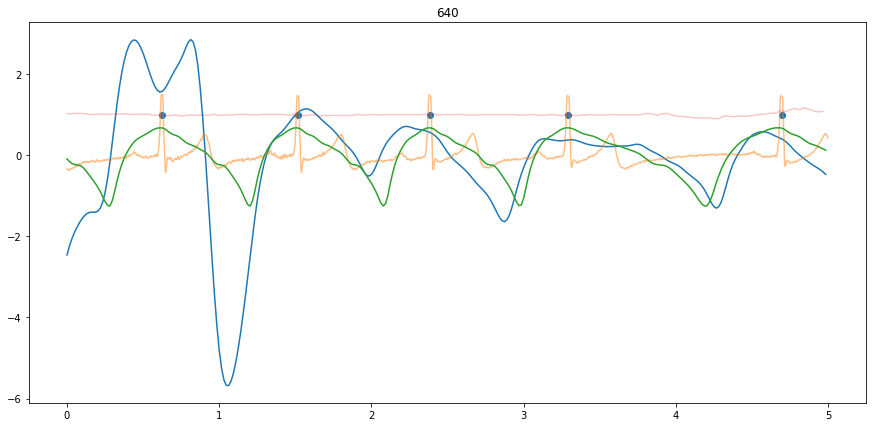

In [86]:
deb=k*64
offset=118
step=5
start_peak=((deb)/64)*700
end_peak=((deb+step*64)/64)*700
rpeak=[]
for peak in peaks_cut:
    if (start_peak<=peak) and (peak<=end_peak):
        rpeak.append(peak)
rpeak_t=(np.array(rpeak)/700)-(deb/64)
ecg=ecg_cut[int(start_peak):int(end_peak)]
Y=np.ones(len(rpeak_t))
bvp=bvp_cut[offset+deb:offset+deb+step*64]
cleanbvp=fakeppg_64hz[deb:deb+step*64]
normacc=acc[(offset+deb)//2:(offset+deb+step*64)//2]
plt.figure(figsize=(15,7))
plt.plot(np.arange(0,len(bvp)/64,1/64),bvp/50)
plt.scatter(rpeak_t,Y)
plt.plot(np.arange(0,len(ecg)/700,1/700),ecg,alpha=0.5)
plt.plot(np.arange(0,len(bvp)/64,1/64),cleanbvp/50)
plt.plot(np.arange(0,len(normacc)/32,1/32),normacc,alpha=0.25)
plt.title(k)